## Reading in the data

In [1]:
## Import the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix

import math



In [2]:
anp_df = pd.read_pickle(r'anp.pickle') #feather.read_dataframe('data_science_case/anp.feather')
face_df = pd.read_pickle(r'face.pickle') #feather.read_dataframe('data_science_case/face.feather')
image_df = pd.read_pickle(r'image_data.pickle') #feather.read_dataframe('data_science_case/image_data.feather')
metrics_df = pd.read_pickle(r'image_metrics.pickle') #feather.read_dataframe('data_science_case/image_metrics.feather')
object_labels_df = pd.read_pickle(r'object_labels.pickle') #feather.read_dataframe('data_science_case/object_labels.feather')
survey_df = pd.read_pickle(r'survey.pickle') #feather.read_dataframe('data_science_case/survey.feather')
celebrity_df = pd.read_pickle(r'celebrity.pickle') #feather.read_dataframe('data_science_case/survey.feather')


## Data aggregatie

In [3]:
#####################################
## OBJECTS DATA
#####################################
df = object_labels_df.groupby("data_amz_label").count().reset_index() ## 2101 possible objects , dit is te veel
df[df['image_id']>500].reset_index() ## 48 objecten hebben meer dan 500 observaties, laten we 48 kolommen maken
list_met_columns = df[df['image_id']>500].data_amz_label.tolist() ## een lijst met alle kollommen die we willen
df = object_labels_df[object_labels_df.data_amz_label.isin(list_met_columns)] ## Filter alle labels die niet vaker voor komen dan 500 keer resulteert in 108k regels
df = df[['image_id','data_amz_label']] ## selecting only relevant columns (every confidence is >0.7)
df_object = df.pivot_table(index='image_id', columns='data_amz_label', aggfunc=len, fill_value=0) ## Pivot count (looks like len)
df_object = df_object.reset_index()
df_object.head()

data_amz_label,image_id,Alcohol,Animal,Art,Beverage,Blossom,Bottle,Bowl,Brochure,Cake,...,Plant,Portrait,Poster,Potted Plant,Selfie,Smile,Text,Tree,Vehicle,Water
0,1000004599066965477_545497348,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000059425592054064_703978203,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,1000080765059521113_31736205,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000097452173278518_206726006,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000118559875482297_555477511,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [4]:
#####################################
## FACE --> EMO
#####################################
df = face_df[['image_id','face_id','face_emo','emo_confidence']] ## selecting the emotion's
emo_face =pd.pivot_table(df, index= ['image_id'],columns ='face_emo',values = 'emo_confidence').fillna(0) ## Gemiddelde emotie per foto
emo_face = emo_face.reset_index()
emo_face.head()


#####################################
## FACE --> PEOPLE en GENDER
#####################################
f = lambda x: x["image_id"].split("_")[1]  ## Maak functie aan

df_people_in_pic = face_df[['image_id','face_id']].drop_duplicates()
df_people_in_pic['user_id']= df_people_in_pic.apply(f, axis=1)
df_people_in_pic.drop(columns = 'image_id',axis=1,inplace=True)
df_people_in_pic = df_people_in_pic.drop_duplicates()

df_aantal_people_in_pic = df_people_in_pic.groupby(['user_id']).count().reset_index()
df_aantal_people_in_pic.columns = ['user_id', 'aantal_personen']
df_aantal_people_in_pic


df = face_df[['image_id','face_id','face_gender']].drop_duplicates()
df['user_id']= df.apply(f, axis=1)
df.drop(columns = 'image_id',axis=1,inplace=True)
df = df.drop_duplicates()



df = df[df['face_gender'] == 'Male']  ## Select only males
df = df.groupby('user_id').count().reset_index()
df.columns = ['user_id', 'aantal_mannen', 'mag_weg']
df_aantal_mannen_in_pic = df[['user_id', 'aantal_mannen']]
people = pd.merge(df_aantal_people_in_pic, df_aantal_mannen_in_pic, how='left', on='user_id').fillna(0)
people['aantal_vrouwen'] = people.aantal_personen - people.aantal_mannen 
people['ratio_mannen']  = people.aantal_mannen / people.aantal_personen 
people['ratio_vrouwen']  = people.aantal_vrouwen / people.aantal_personen 

people.head()



#####################################
## FACE --> PEOPLE en GENDER
#####################################
df = face_df[['image_id','face_id','face_age_range_high','face_age_range_low']].drop_duplicates()
df['gem_leeftijd'] = (df.face_age_range_high + df.face_age_range_low ) / 2 
df = df[['image_id','face_id','gem_leeftijd']]

def roundup(x):
    return str(int((x+5)/10)*10) 

df['nearest_decade_leeftijd'] = df.gem_leeftijd.apply(roundup)
df = df[['image_id','face_id','nearest_decade_leeftijd']]
leeftijd_mensen_in_foto = df.pivot_table(index='image_id', columns='nearest_decade_leeftijd', aggfunc=len, fill_value=0) ## Pivot count (looks like len)
leeftijd_mensen_in_foto = leeftijd_mensen_in_foto.reset_index()
leeftijd_mensen_in_foto.columns = ['_'.join(col) for col in leeftijd_mensen_in_foto.columns]
leeftijd_mensen_in_foto.rename(columns={'image_id_': 'image_id'}, inplace=True)
leeftijd_mensen_in_foto.head() 

,image_id,face_id_0,face_id_10,face_id_20,face_id_30,face_id_40,face_id_50,face_id_60,face_id_70,face_id_80
0,1000126179441391393_30837828,0,2,0,3,3,0,0,0,0
1,1000135251972767429_31447990,0,0,0,1,0,0,0,0,0
2,1000159024449036821_265063047,0,0,0,2,0,0,0,0,0
3,1000185226634350811_276232195,0,0,0,0,1,0,0,0,0
4,1000204070831242247_143854846,0,0,0,1,0,0,0,0,0


In [5]:
#####################################
## ANP --> ANP
#####################################
# anp_df.anp_label.value_counts() ## 3864 different lengts, laten we enkel pakken met count groter dan 500
df = anp_df[['image_id','anp_label','anp_sentiment']]
df_count = df.groupby("anp_label").count().reset_index() 
list_met_columns = df_count[df_count['image_id']>500].anp_label.tolist() ## een lijst met alle kollommen die we willen (81)

df = df[df.anp_label.isin(list_met_columns)] ## Filter alle labels die niet vaker voor komen dan 500 keer resulteert in 108k regels
anp = df.pivot_table(index='image_id', columns='anp_label', fill_value=0) ## Pivot mean is default
anp = anp.reset_index()
anp.columns = ['_'.join(col) for col in anp.columns]
anp.rename(columns={'image_id_': 'image_id'}, inplace=True)
anp.head()


#####################################
## ANP --> Sentiment
#####################################
# anp_df.emotion_label.value_counts() ## 24 different lengts
df = anp_df[['image_id','emotion_label','emotion_score']]
emotion_score = df.pivot_table(index='image_id', columns='emotion_label', fill_value=0) ## Pivot mean is default
emotion_score = emotion_score.reset_index()
emotion_score.columns = ['_'.join(col) for col in emotion_score.columns]
emotion_score.rename(columns={'image_id_': 'image_id'}, inplace=True)
emotion_score.head()




,image_id,emotion_score_acceptance,emotion_score_admiration,emotion_score_amazement,emotion_score_anger,emotion_score_annoyance,emotion_score_anticipation,emotion_score_apprehension,emotion_score_boredom,emotion_score_disgust,...,emotion_score_joy,emotion_score_loathing,emotion_score_pensiveness,emotion_score_rage,emotion_score_sadness,emotion_score_serenity,emotion_score_surprise,emotion_score_terror,emotion_score_trust,emotion_score_vigilance
0,1000004599066965477_545497348,0.0,0.0,0.196933,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.11260,0.0,0.0000,0.0,0.0,0.0
1,1000059425592054064_703978203,0.0,0.0,0.346800,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.11555,0.0,0.2026,0.0,0.0,0.0
2,1000065308809420330_46329534,0.0,0.0,0.171525,0.0,0.0987,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0000,0.0,0.0,0.0
3,1000080765059521113_31736205,0.0,0.0,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.21565,0.0,0.0,0.0,0.12340,0.0,0.0000,0.0,0.0,0.0
4,1000097452173278518_206726006,0.0,0.0,0.198100,0.0,0.0000,0.0,0.0,0.0,0.0,...,0.40130,0.0,0.0,0.0,0.09745,0.0,0.0000,0.0,0.0,0.0


In [6]:
#####################################
## IMAGE
#####################################

# image_df.image_id.is_unique ## Image is unique
## DROP COLOMMEN DIE GEEN VOORSPELKRACHT HEBBEN
# image_df.drop(columns = ['image_id','image_link','image_url','user_full_name','user_name', 'user_website','user_profile_pic', 'user_bio'], inplace=True )

##FILTER PLAT SLAAN

# image_df.image_filter.value_counts() ## ongv. 30
df = image_df[['user_id','image_filter']]
# df_count = df.groupby("image_filter").count().reset_index() 
df_filter = df.pivot_table(index='user_id', columns='image_filter', aggfunc= len ,fill_value=0)
df_filter = df_filter.reset_index()
df_filter.columns = [str(col) + '_filter' for col in df_filter.columns]
df_filter.rename(columns={'user_id_filter': 'user_id'}, inplace=True)
## Waar kunnen we gemiddelde van nemen

df = image_df[['user_id','image_height','image_width','data_memorability']]

df_mean_vars = df.groupby('user_id').mean().reset_index()


df = image_df[['user_id','user_followed_by','user_follows','user_posted_photos']]
df['aantal_fotos'] = 1 
df_sum_vars = df.groupby('user_id').mean().reset_index() ## Moet ook mean zijn, want haalt niet uit

df_sum_vars.shape  #159
df_mean_vars.shape #159
df_filter.shape #159

temp_df = pd.merge(df_sum_vars, df_mean_vars, how='inner', on='user_id')
image_df_user = pd.merge(temp_df, df_filter, how='inner', on='user_id')
image_df_user.head()



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,user_id,user_followed_by,user_follows,user_posted_photos,aantal_fotos,image_height,image_width,data_memorability,1977_filter,Aden_filter,...,Slumber_filter,Stinson_filter,Sutro_filter,Toaster_filter,Unknown_filter,Valencia_filter,Vesper_filter,Walden_filter,Willow_filter,X-Pro II_filter
0,1097967773,53.0,154.0,282.0,1,636.730496,632.056738,0.843239,0,18,...,5,6,0,0,1,19,0,0,0,5
1,11520833,201.0,299.0,312.0,1,617.157051,617.166667,0.819178,2,0,...,0,0,9,3,1,10,0,3,0,9
2,1223036636,169.0,159.0,48.0,1,640.000000,640.000000,0.869481,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1224423305,1.0,18.0,41.0,1,432.365854,593.170732,0.790601,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1249457735,66.0,93.0,30.0,1,645.333333,640.000000,0.804556,0,1,...,0,0,1,0,0,0,0,0,6,2


In [7]:
#####################################
## Metrix
#####################################
metrics_df['user_id']=metrics_df.apply(f, axis=1)
metrics_df = metrics_df.groupby('image_id').max() ## op een of andere manier werkt drop_duplicates niet vaagg...
metrics_df = metrics_df.reset_index()
df = metrics_df[['user_id','comment_count','like_count']]
metrics_df_user = df.groupby('user_id').mean().reset_index()
metrics_df_user.head()

,user_id,comment_count,like_count
0,1097967773,0.731183,5.892473
1,11520833,0.356557,5.540984
2,1223036636,1.978723,11.340426
3,1224423305,0.000000,0.052632
4,1249457735,0.241379,5.689655


In [8]:
#####################################
## IMAGE
#####################################
# survey_df.info()

survey_df.id.is_unique ## Image is unique

True

In [9]:
#####################################
## CELEB
#####################################
# celebrity_df.image_id.is_unique
# celebrity_df.head(20)
# celebrity_df.face_celebrity_name.value_counts() #2177 counts
# GRootste is 20 en gaat heel snel naar 4/5 hier zit geen voorspelende waarde in!

In [10]:
#####################################
## Analyse op aantallen
#####################################

emo_face.shape#(15957, 7)   NIet elke foto heeft mensen erin
df_object.shape#(31051, 48) Niet elke foto heeft een getraind object, gelukkig wel veel gevonden
emotion_score.shape#(41292, 24) Voor paar fotos niet gevuld
leeftijd_mensen_in_foto.shape#(15957, 9)   NIet elke foto heeft mensen erin
# people.shape#(15957, 6)   NIet elke foto heeft mensen erin
metrics_df.shape#(35803, 4) ##RAAR dat dit niet voor elke gevuld is.... Denk dat de data die we hebben gekregen beetje corrupt is, zaten ook duplicates tussen
image_df.shape#(41206, 18) ## dit zijn alle fotos
anp.shape#(22377, 82) ## We hebben hierin gesneden dus dit kan kloppen

(22377, 82)

In [11]:
#####################################
## User id uit elke extracten
#####################################
f = lambda x: x["image_id"].split("_")[1]  ## Maak functie aan

emo_face['user_id'] = emo_face.apply(f, axis=1)
df_object['user_id'] =df_object.apply(f, axis=1)
emotion_score['user_id']= emotion_score.apply(f, axis=1)
leeftijd_mensen_in_foto['user_id']= leeftijd_mensen_in_foto.apply(f, axis=1)
anp['user_id']=anp.apply(f, axis=1)


In [12]:
#####################################
## Aggegreren op user_id
#####################################
emo_user_face =emo_face.loc[:, emo_face.columns != 'image_id'].groupby('user_id').mean().reset_index()
object_user = df_object.loc[:, df_object.columns != 'image_id'].groupby('user_id').sum().reset_index()
emo_user =emotion_score.loc[:, emotion_score.columns != 'image_id'].groupby('user_id').mean().reset_index()
leeftijd_mensen_in_foto_user = leeftijd_mensen_in_foto.loc[:, leeftijd_mensen_in_foto.columns != 'image_id'].groupby('user_id').sum().reset_index()
anp_user =anp.loc[:, anp.columns != 'image_id'].groupby('user_id').mean().reset_index()
# people ## deze is al op niveau van user
# image_df_user ## deze is ook al op niveau

In [13]:
emo_user['user_id'] = emo_user['user_id'].astype('int64')
object_user['user_id'] = object_user['user_id'].astype('int64')
leeftijd_mensen_in_foto_user['user_id'] = leeftijd_mensen_in_foto_user['user_id'].astype('int64')
anp_user['user_id'] = anp_user['user_id'].astype('int64')
people['user_id'] = people['user_id'].astype('int64')
image_df_user['user_id'] = image_df_user['user_id'].astype('int64')
metrics_df_user['user_id'] = metrics_df_user['user_id'].astype('int64')
emo_user_face['user_id'] = emo_user_face['user_id'].astype('int64')

temp = pd.merge(survey_df, emo_user, how='left', left_on='insta_user_id', right_on='user_id')
temp2 = pd.merge(temp, object_user, how='left', left_on='insta_user_id', right_on='user_id')
temp3 = pd.merge(temp2, leeftijd_mensen_in_foto_user, how='left', left_on='insta_user_id', right_on='user_id')
temp4 = pd.merge(temp3, anp_user, how='left', left_on='insta_user_id', right_on='user_id')
temp5 = pd.merge(temp4, people, how='left', left_on='insta_user_id', right_on='user_id')
temp6 = pd.merge(temp5, image_df_user, how='left', left_on='insta_user_id', right_on='user_id')
temp7 = pd.merge(temp6, metrics_df_user, how='left', left_on='insta_user_id', right_on='user_id')
platte_df = pd.merge(temp7, emo_user_face, how='left', left_on='insta_user_id', right_on='user_id')

platte_df.shape



(161, 282)

In [14]:
## Alle kolommmen bekijken
from IPython.display import display
pd.options.display.max_columns = None
display(platte_df.head())

,index,id,gender,born,education,employed,income,A_2,N_1,P_1,E_1,A_1,H_1,M_1,R_1,M_2,E_2,LON,H_2,P_2,N_2,A_3,N_3,E_3,H_3,R_2,M_3,R_3,P_3,HAP,participate,insta_user_id,completed,start_q,end_q,network_id,P,E,R,M,A,PERMA,N_EMO,P_EMO,imagecount,private_account,user_id_x,emotion_score_acceptance,emotion_score_admiration,emotion_score_amazement,emotion_score_anger,emotion_score_annoyance,emotion_score_anticipation,emotion_score_apprehension,emotion_score_boredom,emotion_score_disgust,emotion_score_distraction,emotion_score_ecstasy,emotion_score_fear,emotion_score_grief,emotion_score_interest,emotion_score_joy,emotion_score_loathing,emotion_score_pensiveness,emotion_score_rage,emotion_score_sadness,emotion_score_serenity,emotion_score_surprise,emotion_score_terror,emotion_score_trust,emotion_score_vigilance,user_id_y,Alcohol,Animal,Art,Beverage,Blossom,Bottle,Bowl,Brochure,Cake,Canine,Car,Cat,Clothing,Collage,Couch,Crowd,Cup,Dessert,Dog,Drink,Electronics,Face,Female,Flora,Flower,Flyer,Food,Furniture,Glass,Goggles,Human,Mammal,Musical Instrument,Outdoors,Paper,People,Person,Pet,Plant,Portrait,Poster,Potted Plant,Selfie,Smile,Text,Tree,Vehicle,Water,user_id_x,face_id_0,face_id_10,face_id_20,face_id_30,face_id_40,face_id_50,face_id_60,face_id_70,face_id_80,user_id_y,anp_sentiment_bad_hair,anp_sentiment_bad_sign,anp_sentiment_baked_goods,anp_sentiment_beautiful_baby,anp_sentiment_big_glasses,anp_sentiment_classic_toy,anp_sentiment_colorful_hair,anp_sentiment_comic_life,anp_sentiment_comic_sans,anp_sentiment_compact_disc,anp_sentiment_crazy_face,anp_sentiment_cute_baby,anp_sentiment_cute_cat,anp_sentiment_cute_couple,anp_sentiment_cute_dog,anp_sentiment_cute_guy,anp_sentiment_cute_kitty,anp_sentiment_dark_chocolate,anp_sentiment_double_exposition,anp_sentiment_double_portrait,anp_sentiment_dyed_hair,anp_sentiment_dynamic_light,anp_sentiment_early_days,anp_sentiment_fake_lomo,anp_sentiment_fake_vintage,anp_sentiment_fitting_room,anp_sentiment_frozen_food,anp_sentiment_funny_cats,anp_sentiment_funny_dog,anp_sentiment_funny_quotes,anp_sentiment_funny_signs,anp_sentiment_funny_stuff,anp_sentiment_good_day,anp_sentiment_good_food,anp_sentiment_grand_baby,anp_sentiment_grilled_chicken,anp_sentiment_grumpy_cat,anp_sentiment_hairless_cat,anp_sentiment_happy_baby,anp_sentiment_happy_birthday,anp_sentiment_happy_couple,anp_sentiment_healthy_food,anp_sentiment_hot_drink,anp_sentiment_hot_guys,anp_sentiment_hot_men,anp_sentiment_hot_sauce,anp_sentiment_hot_site,anp_sentiment_impossible_project,anp_sentiment_inspirational_quotes,anp_sentiment_inspiring_quotes,anp_sentiment_late_dinner,anp_sentiment_mad_magazine,anp_sentiment_mixed_breed,anp_sentiment_natural_hair,anp_sentiment_old_friends,anp_sentiment_plastic_bullet,anp_sentiment_plastic_surgery,anp_sentiment_raw_food,anp_sentiment_raw_milk,anp_sentiment_real_food,anp_sentiment_real_talk,anp_sentiment_rounded_corners,anp_sentiment_sexy_boy,anp_sentiment_sexy_man,anp_sentiment_short_sale,anp_sentiment_short_stories,anp_sentiment_silly_faces,anp_sentiment_sleepy_dog,anp_sentiment_small_dog,anp_sentiment_smiling_baby,anp_sentiment_sour_cream,anp_sentiment_sticky_notes,anp_sentiment_straight_hair,anp_sentiment_sweet_baby,anp_sentiment_sweet_tea,anp_sentiment_temporary_tattoos,anp_sentiment_true_story,anp_sentiment_ugly_sweater,anp_sentiment_visual_identity,anp_sentiment_visual_journal,anp_sentiment_wise_words,user_id_x,aantal_personen,aantal_mannen,aantal_vrouwen,ratio_mannen,ratio_vrouwen,user_id_y,user_followed_by,user_follows,user_posted_photos,aantal_fotos,image_height,image_width,data_memorability,1977_filter,Aden_filter,Amaro_filter,Apollo_filter,Ashby_filter,Brannan_filter,Brooklyn_filter,Charmes_filter,Clarendon_filter,Crema_filter,Dogpatch_filter,Earlybird_filter,Gingham_filter,Ginza_filter,Gotham_filter,Hefe_filter,Helena_filter,Hudson_filter,Inkwell_filter,Juno_filter,Kelvin_filter,Lark_filter,Lo-fi_filter,Ludwig_filter,Maven_filter,Mayfair_filter,Moon_filter,Nashville_filter,Normal_filter,Perp

In [15]:
platte_df.shape

(161, 282)

## Einde data aggregatie

In [134]:
platte_df = platte_df.dropna()
platte_df = platte_df.drop(labels='user_id_y', axis=1)

## K-Fold

In [135]:
from sklearn.model_selection import KFold


# create a k fold with 5 splits, with a fixed random state
kf = KFold(n_splits = 5, shuffle = True, random_state = 1)
result = next(kf.split(platte_df), None)

# create train and test pandas dataframe, with the selected distributions
train = platte_df.iloc[result[0]]
test =  platte_df.iloc[result[1]]

print (result[0])
print (result[1])

[  0   1   2   3   4   6   7   8   9  10  11  12  13  15  16  18  20  21
  22  23  24  25  26  27  28  30  32  34  37  38  40  41  43  44  46  47
  48  49  50  51  52  53  55  57  60  61  63  64  66  67  68  69  70  71
  72  74  75  76  79  80  81  82  84  85  86  87  88  89  90  91  93  94
  95  96  97  98  99 100 101 102 104 105 107 108 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 131 132 133 135
 136 137 138 139]
[  5  14  17  19  29  31  33  35  36  39  42  45  54  56  58  59  62  65
  73  77  78  83  92 103 106 109 130 134]


In [166]:
#train.iloc[:,35:38] 

In [165]:
#train.iloc[22:27,47:100] 

In [167]:
#train.iloc[22:27,47:100] 

## Feature_selection

In [192]:
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt

In [208]:
def feature_select(Fit_variables, target_variable , n_variables):
    # create a base classifier used to evaluate a subset of attributes
    model = LogisticRegression()
    # create the RFE model and select 3 attributes
    rfe = RFE(model, n_variables)
    rfe = rfe.fit(Fit_variables , target_variable.astype('str'))
    return rfe
        
def find_column_names_for_ranking(dataset, rfe):
    # calculate index of ranking
    rankingIndex = []
    for x in range(len(rfe.ranking_)):
        if rfe.ranking_[x] == 1:
            rankingIndex.append(x)
            
    # find columns        
    return dataset.iloc[: ,rankingIndex].columns

# select features from the variables with as target the P of the PERMA score, and select top 15 variables
rfe = feature_select(train.iloc[:,47:100] , train.iloc[:,36], 15)
# uncomment to see select binary output
#print(rfe.support_)
#print(rfe.ranking_)

# find the corresponding columns of the ranking
ranking = find_column_names_for_ranking(train.iloc[:,47:100], rfe)   
print (ranking)

Index(['emotion_score_amazement', 'Alcohol', 'Animal', 'Blossom', 'Bottle',
       'Brochure', 'Cake', 'Car', 'Cat', 'Cup', 'Dessert', 'Electronics',
       'Flower', 'Flyer', 'Glass'],
      dtype='object')


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


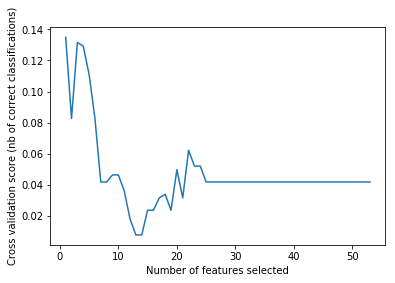

Optimal number of features : 1


In [228]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')

rfecv.fit(train.iloc[:,47:100] , train.iloc[:,36].astype('str'))


# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Optimal number of features : %d" % rfecv.n_features_)

In [213]:
len(train['P'])


112

## Accuracy

In [222]:
def accuracy(ranking_variables, target):

    clf = LogisticRegression(random_state=0, solver='lbfgs',
                             multi_class='multinomial').fit(ranking_variables, target)
   
    clf.predict(ranking_variables)
    clf.predict_proba(ranking_variables) 
    score = clf.score(ranking_variables, target)
    return score
    
accuracy(train[ranking], train['P'].astype('str'))

0.6696428571428571

In [245]:
# calculate accuracy from 1 to all variables selected
def calc_accuracy_variables(target):
    scores = []
    for n_variables in range(1,len(train.iloc[:,47:100])+1): 
        rfe = feature_select(train.iloc[:,47:100] , target, n_variables)
        ranking = find_column_names_for_ranking(train.iloc[:,47:100], rfe)   

        score = accuracy(train[ranking], train['P'].astype('str'))
        scores.append(score)
        #print (n_variables," variables, score: ",  score)
    return scores

#calc_accuracy_variables(train['P'])       

PERMA letter:  P
accuracy  0  :  0.19642857142857142
accuracy  10  :  0.5535714285714286
accuracy  20  :  0.7767857142857143
accuracy  30  :  0.8571428571428571
accuracy  40  :  0.8571428571428571
accuracy  50  :  0.8571428571428571
accuracy  60  :  0.8571428571428571
accuracy  70  :  0.8571428571428571
accuracy  80  :  0.8571428571428571
accuracy  90  :  0.8571428571428571
accuracy  100  :  0.8571428571428571
accuracy  110  :  0.8571428571428571


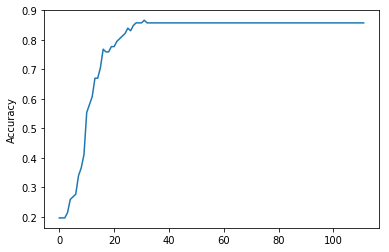

PERMA letter:  E
accuracy  0  :  0.16071428571428573
accuracy  10  :  0.45535714285714285
accuracy  20  :  0.7142857142857143
accuracy  30  :  0.8571428571428571
accuracy  40  :  0.8571428571428571
accuracy  50  :  0.8571428571428571
accuracy  60  :  0.8571428571428571
accuracy  70  :  0.8571428571428571
accuracy  80  :  0.8571428571428571
accuracy  90  :  0.8571428571428571
accuracy  100  :  0.8571428571428571
accuracy  110  :  0.8571428571428571


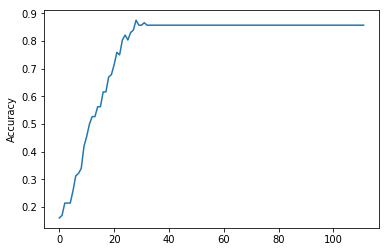

PERMA letter:  R
accuracy  0  :  0.15178571428571427
accuracy  10  :  0.45535714285714285
accuracy  20  :  0.7321428571428571
accuracy  30  :  0.8571428571428571
accuracy  40  :  0.8660714285714286
accuracy  50  :  0.8571428571428571
accuracy  60  :  0.8571428571428571
accuracy  70  :  0.8571428571428571
accuracy  80  :  0.8571428571428571
accuracy  90  :  0.8571428571428571
accuracy  100  :  0.8571428571428571
accuracy  110  :  0.8571428571428571


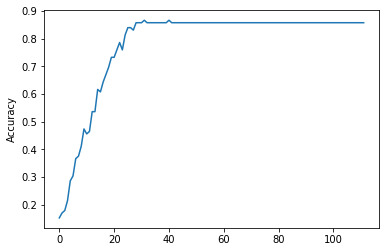

PERMA letter:  M
accuracy  0  :  0.15178571428571427
accuracy  10  :  0.42857142857142855
accuracy  20  :  0.7142857142857143
accuracy  30  :  0.8571428571428571
accuracy  40  :  0.8660714285714286
accuracy  50  :  0.8571428571428571
accuracy  60  :  0.8571428571428571
accuracy  70  :  0.8571428571428571
accuracy  80  :  0.8571428571428571
accuracy  90  :  0.8571428571428571
accuracy  100  :  0.8571428571428571
accuracy  110  :  0.8571428571428571


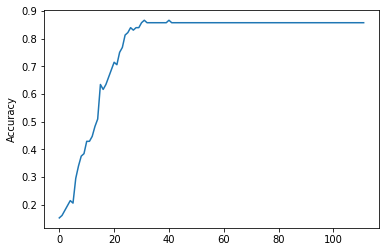

PERMA letter:  A
accuracy  0  :  0.15178571428571427
accuracy  10  :  0.4017857142857143
accuracy  20  :  0.7142857142857143
accuracy  30  :  0.8571428571428571
accuracy  40  :  0.8571428571428571
accuracy  50  :  0.8571428571428571
accuracy  60  :  0.8571428571428571
accuracy  70  :  0.8571428571428571
accuracy  80  :  0.8571428571428571
accuracy  90  :  0.8571428571428571
accuracy  100  :  0.8571428571428571
accuracy  110  :  0.8571428571428571


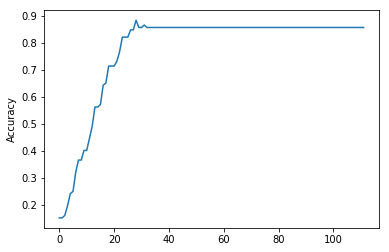

In [250]:
for letter in 'PERMA':
    scores = calc_accuracy_variables(train[letter])
    print ("PERMA letter: ", letter)
    for x in range(len(scores)):
        if x % 10 == 0:
            print ("accuracy ", x, " : ", scores[x])
    
    plt.plot([x for x in range(len(scores))], scores)
    plt.ylabel('Accuracy')
    plt.show()

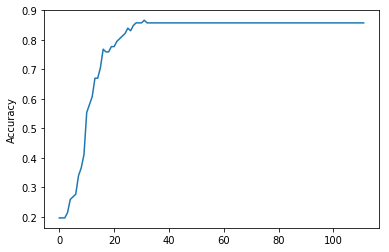

In [242]:
plt.plot([x for x in range(len(scores))], scores)
plt.ylabel('Accuracy')
plt.show()